In [1]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display
import json
from pathlib import Path
import sys

(c) We now consider that this consumer has installed a battery, and analyze the impact
on its flexibility and profits.

iv. (1 point) Implement this optimization problem in a programming language of your
choice. Provide a well-documented working code.

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[rosetta2] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 193 rows, 192 columns and 432 nonzeros
Model fingerprint: 0xf982a31a
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 100 rows and 27 columns
Presolve time: 0.00s
Presolved: 93 rows, 165 columns, 304 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.2060000e+31   6.855000e+31   2.206000e+01      0s
      62    2.7125594e+01   0.000000e+00   0.000000e+00      0s

Solved in 62 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.712559444e+01

Hourly schedule (hours 0..23):
 t | price | pv_avail | r (ref) | x (load) | d (dev) | u (pv used) | p_ch | p_dis | SOC | impo

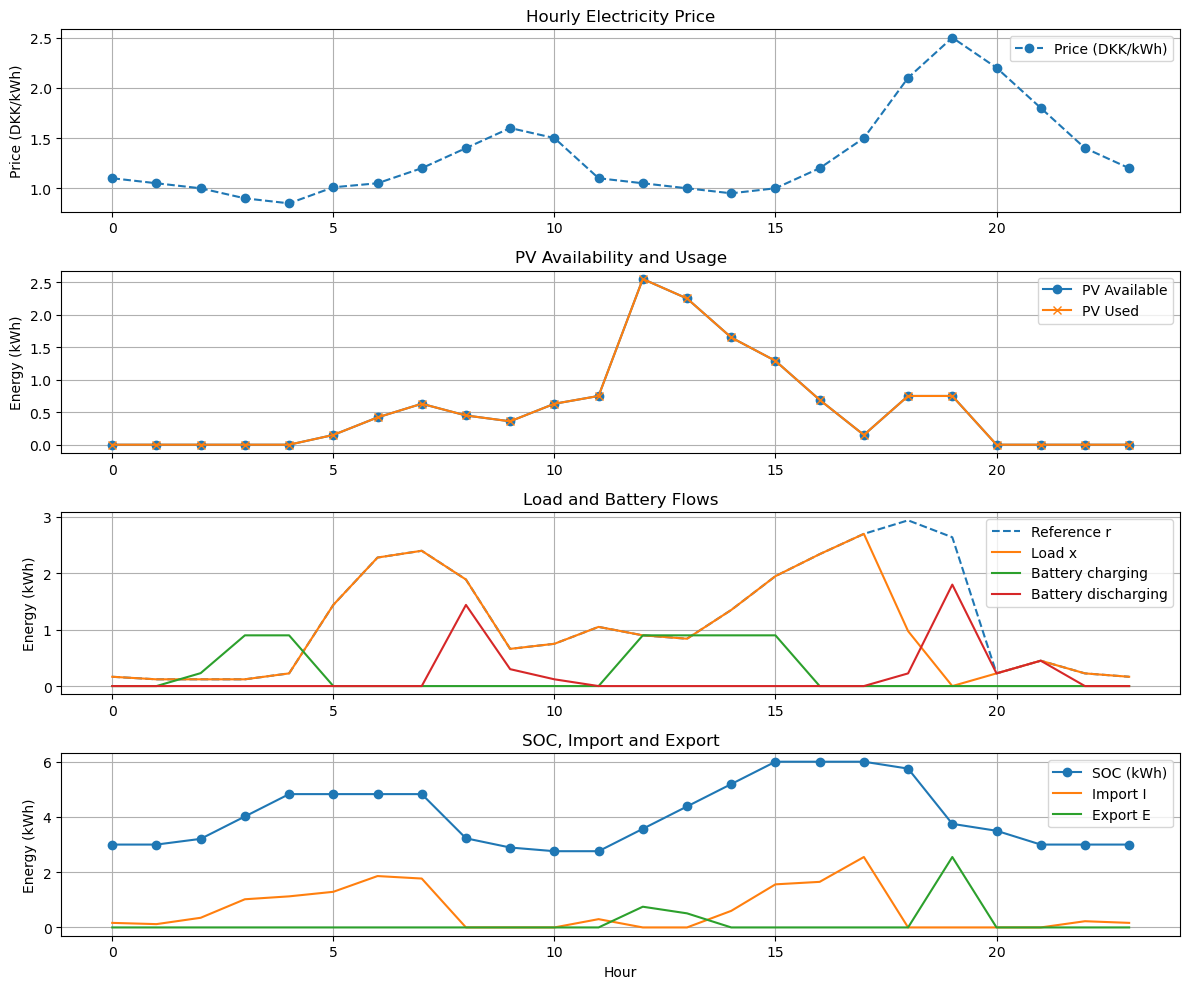

In [4]:
# Utility to load JSON
def load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None

# Paths
base_folder = Path("data/question_1c/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preferences.json"

appliance_params = load_json(appliance_path)
bus_params = load_json(bus_path)
consumer_params = load_json(consumer_path)
DER_production = load_json(der_prod_path)
usage_pref = load_json(usage_pref_path)

# Single consumer / bus assumption for this assignment
consumer = consumer_params[0]
bus = bus_params[0]

# Extract specs
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

storage_spec = appliance_params["storage"][0]
storage_id = storage_spec["storage_id"]
C = float(storage_spec["storage_capacity_kWh"])  # capacity (kWh)
max_charging_power_ratio = float(storage_spec["max_charging_power_ratio"])
max_discharging_power_ratio = float(storage_spec["max_discharging_power_ratio"])
eta_ch = float(storage_spec["charging_efficiency"])
eta_dis = float(storage_spec["discharging_efficiency"])

P_ch_max = max_charging_power_ratio * C  # kW (kWh per hour)
P_dis_max = max_discharging_power_ratio * C


storage_prefs = usage_pref[0].get("storage_preferences", [])

initial_soc_ratio = float(storage_prefs[0]["initial_soc_ratio"])
final_soc_ratio = float(storage_prefs[0]["final_soc_ratio"])

SOC0 = initial_soc_ratio * C
SOC_final_required = final_soc_ratio * C


prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit("Expected 24 hourly prices; got %d" % len(prices))

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")

pv_avail = [pv_max_kW * float(r) for r in der_profile]

# Usage preferences: reference hourly profile ratios
load_prefs = usage_pref[0].get("load_preferences", [])
if not load_prefs:
    raise SystemExit("No load_preferences found in usage_preference.json")
lp0 = load_prefs[0]
hourly_profile_ratio = lp0.get("hourly_profile_ratio", None)
if hourly_profile_ratio is None or len(hourly_profile_ratio) != 24:
    raise SystemExit("Expected a 24-entry hourly_profile_ratio for the load in usage_preference.json")

# Reference profile r_t = ratio * max_load (kWh per hour)
r = [float(ratio) * load_max_kWh for ratio in hourly_profile_ratio]

# Discomfort penalty gamma (DKK per kWh)
gamma = 2

T = list(range(24))

# Build model
m = gp.Model("consumer_flex_lp_with_battery_and_discomfort")
m.setParam('OutputFlag', 1)

# Variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")          # cap by PV availability constraints
I = m.addVars(T, lb=0.0, name="I")
E = m.addVars(T, lb=0.0, name="E")
d = m.addVars(T, lb=0.0, name="d")         # absolute deviation variables

# Battery variables
p_ch = m.addVars(T, lb=0.0, ub=P_ch_max, name="p_ch")   # charging power (kW)
p_dis = m.addVars(T, lb=0.0, ub=P_dis_max, name="p_dis") # discharging power (kW)
SOC = m.addVars(T, lb=0.0, ub=C, name="SOC")            # SOC at end of each hour (kWh)

# PV availability constraints
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Energy balance (including battery)
# I - E + u + p_dis = x + p_ch
for t in T:
    m.addConstr(I[t] - E[t] + u[t] + p_dis[t] == x[t] + p_ch[t], name=f"balance_{t}")

# Load upper bound (already in var definition, but keep for clarity)
for t in T:
    m.addConstr(x[t] <= load_max_kWh, name=f"load_cap_{t}")

# Deviation linearization constraints: d_t >= x_t - r_t and d_t >= r_t - x_t
for t in T:
    m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
    m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")
    # d[t] >= 0 is enforced by variable lb

# Battery SoC dynamics
# SOC[0] = SOC0 + eta_ch * p_ch[0] - (1/eta_dis) * p_dis[0]
# SOC[t] = SOC[t-1] + eta_ch * p_ch[t] - (1/eta_dis) * p_dis[t] for t >= 1
m.addConstr(SOC[0] == SOC0 + eta_ch * p_ch[0] - (1.0/eta_dis) * p_dis[0], name="soc_0")
for t in T[1:]:
    m.addConstr(SOC[t] == SOC[t-1] + eta_ch * p_ch[t] - (1.0/eta_dis) * p_dis[t], name=f"soc_{t}")

# Battery terminal SOC constraint: ensure battery not fully depleted at end of day
m.addConstr(SOC[T[-1]] >= SOC_final_required, name="terminal_soc")

# Battery power limits already set via variable ub (p_ch and p_dis definitions)
# If you also want to explicitly add them as constraints (not necessary because of ub), you can:
# for t in T:
#     m.addConstr(p_ch[t] <= P_ch_max, name=f"ch_cap_{t}")
#     m.addConstr(p_dis[t] <= P_dis_max, name=f"dis_cap_{t}")

# Optionally enforce SOC limits (already via SOC variable ub/lb), but we can add explicit:
min_soc = 0.0  # allow full depth unless you want a minimum safety SOC
for t in T:
    m.addConstr(SOC[t] >= min_soc, name=f"soc_min_{t}")
    m.addConstr(SOC[t] <= C, name=f"soc_max_{t}")


# Objective: energy procurement cost + gamma * sum(d)

energy_cost = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
discomfort_cost = gamma * gp.quicksum(d[t] for t in T)

m.setObjective(energy_cost + discomfort_cost, GRB.MINIMIZE)

# Optimize
m.optimize()

if m.status != GRB.OPTIMAL:
    print("Optimization status:", m.status)

# Results
x_sol = [x[t].X for t in T]
u_sol = [u[t].X for t in T]
I_sol = [I[t].X for t in T]
E_sol = [E[t].X for t in T]
d_sol = [d[t].X for t in T]
p_ch_sol = [p_ch[t].X for t in T]
p_dis_sol = [p_dis[t].X for t in T]
SOC_sol = [SOC[t].X for t in T]

total_import = sum(I_sol)
total_export = sum(E_sol)
total_load = sum(x_sol)
total_pv_used = sum(u_sol)
total_deviation = sum(d_sol)
total_ch = sum(p_ch_sol)
total_dis = sum(p_dis_sol)
objective_value = m.ObjVal

print("\nHourly schedule (hours 0..23):")
print(" t | price | pv_avail | r (ref) | x (load) | d (dev) | u (pv used) | p_ch | p_dis | SOC | import I | export E")
for t in T:
    print(f"{t:2d} | {prices[t]:5.2f} | {pv_avail[t]:7.3f} | {r[t]:7.3f} | {x_sol[t]:7.3f} | {d_sol[t]:7.3f} | {u_sol[t]:10.3f} | {p_ch_sol[t]:5.3f} | {p_dis_sol[t]:6.3f} | {SOC_sol[t]:5.3f} | {I_sol[t]:8.3f} | {E_sol[t]:8.3f}")

print("\nTotals:")
print(f" Total load (sum x):        {total_load:.3f} kWh")
print(f" Total PV used (sum u):     {total_pv_used:.3f} kWh")
print(f" Total charge (sum p_ch):   {total_ch:.3f} kWh")
print(f" Total discharge (sum p_dis): {total_dis:.3f} kWh")
print(f" Total import (sum I):      {total_import:.3f} kWh")
print(f" Total export (sum E):      {total_export:.3f} kWh")
print(f" Total absolute deviation:  {total_deviation:.3f} kWh")
print(f" Objective (total cost):    {objective_value:.3f} DKK")

# Print binding constraints
print("\nBinding constraints (tight):")
for constr in m.getConstrs():
    if abs(constr.Slack) < 1e-6:
        try:
            print(f" {constr.ConstrName} is binding. Dual: {constr.Pi:.6f}")
        except Exception:
            print(f" {constr.ConstrName} is binding.")

# Plot schedule
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(T, prices, label="Price (DKK/kWh)", linestyle='--', marker='o')
plt.ylabel("Price (DKK/kWh)")
plt.title("Hourly Electricity Price")
plt.grid()
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(T, pv_avail, label="PV Available", marker='o')
plt.plot(T, u_sol, label="PV Used", marker='x')
plt.ylabel("Energy (kWh)")
plt.title("PV Availability and Usage")
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(T, r, label="Reference r", linestyle='--')
plt.plot(T, x_sol, label="Load x")
plt.plot(T, p_ch_sol, label="Battery charging")
plt.plot(T, p_dis_sol, label="Battery discharging")
plt.ylabel("Energy (kWh)")
plt.title("Load and Battery Flows")
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(T, SOC_sol, label="SOC (kWh)", marker='o')
plt.plot(T, I_sol, label="Import I")
plt.plot(T, E_sol, label="Export E")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.title("SOC, Import and Export")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
